#### Problem statement:- 
Build a system to predict if the hotel reviews are positive/negative, so that we can address any issues which are in the form of negative feedback.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import plot_roc_curve

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load train dataset 
df = pd.read_csv('train.csv')

In [3]:
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [4]:
df.shape

(38932, 5)

In [5]:
# checking the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
User_ID         38932 non-null object
Description     38932 non-null object
Browser_Used    38932 non-null object
Device_Used     38932 non-null object
Is_Response     38932 non-null object
dtypes: object(5)
memory usage: 1.5+ MB


All features are objects with same count

In [6]:
# Check for null values
df.isnull().sum()

User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

No null values present 

In [7]:
# check unique items count for user id
df.User_ID.nunique()

38932

In [8]:
# we can drop User_ID which is unique and so not required
df.drop('User_ID', inplace=True, axis=1)

In [9]:
# Check for any duplicate values
df.duplicated().sum()

0

In [10]:
df.head()

,Description,Browser_Used,Device_Used,Is_Response
0,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [11]:
# Lets get the count of browser used for giving review
df.Browser_Used.value_counts()

Firefox              7367
Edge                 7134
Google Chrome        4659
InternetExplorer     4588
Mozilla Firefox      4328
Mozilla              3092
Chrome               2470
IE                   2439
Internet Explorer    2103
Safari                390
Opera                 362
Name: Browser_Used, dtype: int64

[]

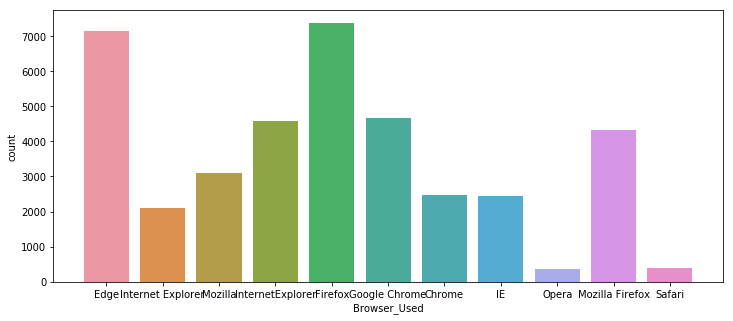

In [12]:
# Lets visualise the browser count
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='Browser_Used')
plt.plot()

In [13]:
# Lets get the count of device type used for giving review
df.Device_Used.value_counts()

Desktop    15026
Mobile     14976
Tablet      8930
Name: Device_Used, dtype: int64

Most of the reviewers used Desktop following Mobile for posting there review

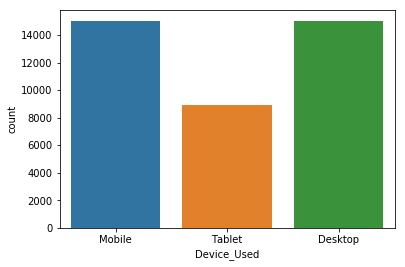

In [14]:
# Lets visualise the device type count
sns.countplot(data=df, x='Device_Used')

In [15]:
# Lets check review response
df.Is_Response.value_counts()

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

In [16]:
# Lets get the percentage
df.Is_Response.value_counts(normalize=True) * 100

happy        68.12134
not happy    31.87866
Name: Is_Response, dtype: float64

68% reviewers have positive response

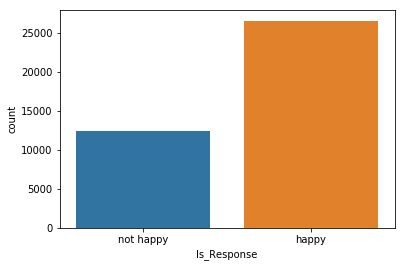

In [17]:
# Lets plot the review response
sns.countplot(data=df, x='Is_Response')

In [18]:
# Label encoding for target
df.Is_Response.replace({'happy':0, 'not happy':1}, inplace=True)

In [19]:
# We can remove Browser_Used and Device_Used which doesn't have any relation to the target
df.drop(columns=['Browser_Used','Device_Used'], axis=1, inplace=True)

In [20]:
df.head()

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,1
1,I stayed at the Crown Plaza April -- - April -...,1
2,I booked this hotel through Hotwire at the low...,1
3,Stayed here with husband and sons on the way t...,0
4,My girlfriends and I stayed here to celebrate ...,1


### Data cleaning and Tokenization

In [21]:
# to lowercase
df['Description'] = df['Description'].str.lower()

# Remove punctuation
df['Description'] = df['Description'].str.replace(r'[^\w\d\s]', ' ')

# replace non-word character with space
df['Description'] = df['Description'].str.replace(r'[@#\$%&\*\(\)\<\>\?\'\":;\,\.\]\[-]', '')
df['Description'] = df['Description'].str.replace(r'\d', '')

# remove numbers
df['Description'] = df['Description'].str.replace(r'\[[0-9]*\]', '')

# Remove extra spaces
df['Description'] = df['Description'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['Description'] = df['Description'].str.replace(r'^\s+|\s+?$', '')

In [22]:
df['Description'].head()

0    the room was kind of clean but had a very stro...
1    i stayed at the crown plaza april april the st...
2    i booked this hotel through hotwire at the low...
3    stayed here with husband and sons on the way t...
4    my girlfriends and i stayed here to celebrate ...
Name: Description, dtype: object

In [23]:
# Remove stopwords
stop_words = stopwords.words('english')
df['Description'] = df['Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [24]:
def wordcloud(data):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 50,
        max_font_size = 30,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

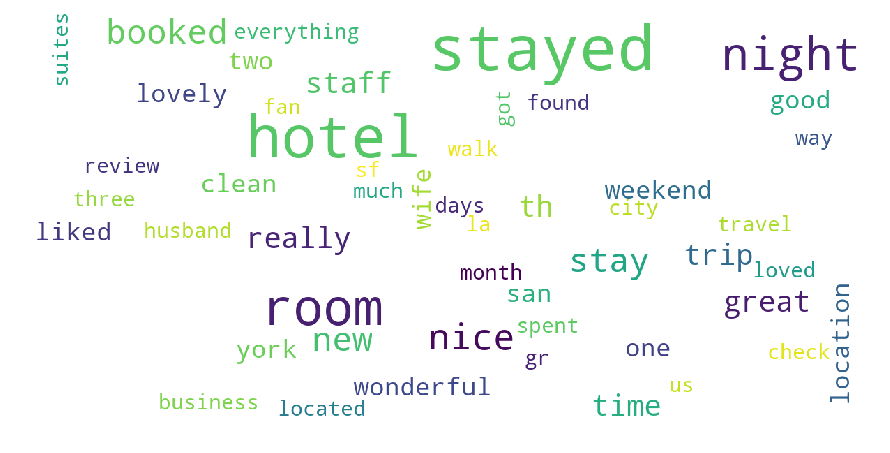

In [25]:
happy = df['Description'][df['Is_Response'] == 0]
wordcloud(happy)

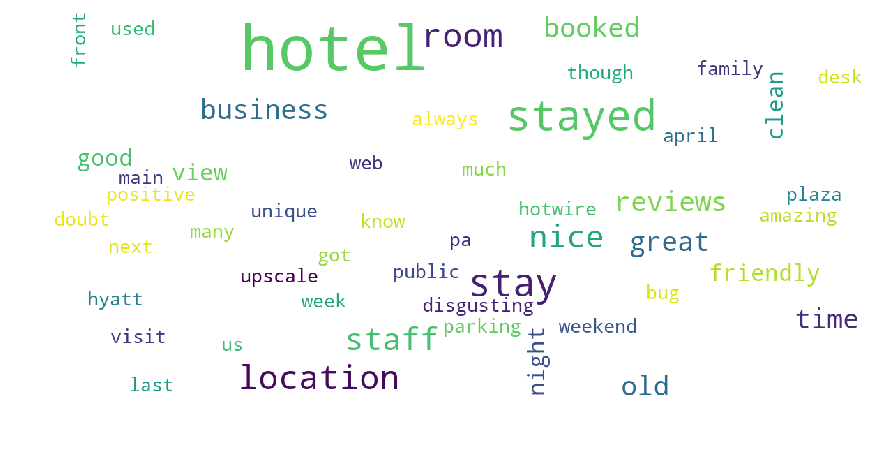

In [26]:
not_happy = df['Description'][df['Is_Response'] == 1]
wordcloud(not_happy)

In [27]:
tf_vec = TfidfVectorizer()
X = tf_vec.fit_transform(df['Description'])
y = df['Is_Response']
X.shape, y.shape

((38932, 45873), (38932,))

In [28]:
# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31145, 45873), (7787, 45873), (31145,), (7787,))

In [63]:
X

<29404x39967 sparse matrix of type '<class 'numpy.float64'>'
	with 1931006 stored elements in Compressed Sparse Row format>

In [33]:
# Put models into Dictionary
models = {"Logistic Regression": LogisticRegression(),
           "KNN": KNeighborsClassifier(),
           "Random Forest": RandomForestClassifier(),
           "Naive Bayes": MultinomialNB() }

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [34]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'Logistic Regression': 0.8846795941954539,
 'KNN': 0.7787337870810325,
 'Random Forest': 0.8310003852574804,
 'Naive Bayes': 0.8099396429947349}

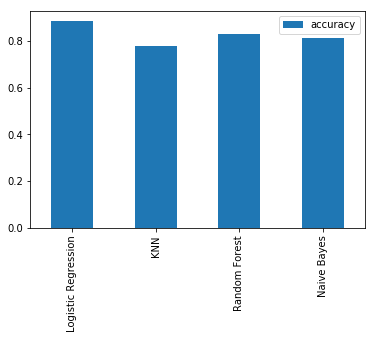

In [35]:
# Compare models
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

In [36]:
def max_acc_score(reg, x, y):
    max_acc_score=0
    for r_state in range(42,101):
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = r_state, test_size=0.20)
        reg.fit(X_train, y_train)
        pred = reg.predict(X_test)
        acc_score=accuracy_score(y_test, pred)
        if acc_score > max_acc_score:
            max_acc_score = acc_score
            final_r_state = r_state
    print("The max accuracy score for", reg, "is: ", max_acc_score, " achieved at", final_r_state)
   

In [37]:
lr = LogisticRegression()
max_acc_score(lr, X, y)

The max accuracy score for LogisticRegression() is:  0.8928984204443303  achieved at 98


In [38]:
knn = KNeighborsClassifier()
max_acc_score(knn, X, y)

The max accuracy score for KNeighborsClassifier() is:  0.7979966611018364  achieved at 61


In [39]:
random_forest = RandomForestClassifier()
max_acc_score(random_forest, X, y)

The max accuracy score for RandomForestClassifier() is:  0.8415307563888532  achieved at 91


In [40]:
nb = MultinomialNB()
max_acc_score(nb, X, y)

The max accuracy score for MultinomialNB() is:  0.8194426608449981  achieved at 71


##### Logistic Regression is giving high accuracy, we can proceed with that.

In [41]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

In [42]:
# Tune LogisticRegression

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                random_state=98,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   random_state=98, verbose=True)

In [43]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 1.623776739188721}

In [44]:
rs_log_reg.score(X_test, y_test)

0.8860922049569796

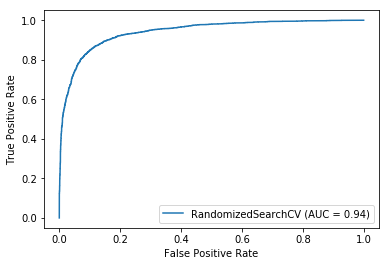

In [45]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rs_log_reg, X_test, y_test)

In [46]:
# Make predictions with tuned model
y_preds = rs_log_reg.predict(X_test)
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[4975  310]
 [ 577 1925]]


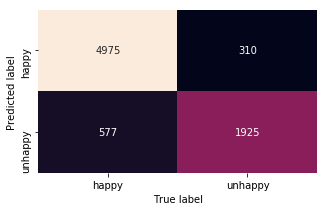

In [47]:

def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False,
                     fmt="d")

    ax.xaxis.set_ticklabels(['happy','unhappy'])
    ax.yaxis.set_ticklabels(['happy','unhappy'])
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
plot_conf_mat(y_test, y_preds)

In [48]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5285
           1       0.86      0.77      0.81      2502

    accuracy                           0.89      7787
   macro avg       0.88      0.86      0.87      7787
weighted avg       0.88      0.89      0.88      7787

